In [1]:
!pip install transformers --q
!pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio===0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html --q
!pip install --upgrade --force-reinstall gdown --q

# Download the dataset from Gdrive

In [6]:

# import gdown

# https://drive.google.com/drive/folders/11mRvsHAkggFEJvG4axH4mmWI6FHMQp7X?usp=sharing

!gdown --folder https://drive.google.com/drive/folders/11mRvsHAkggFEJvG4axH4mmWI6FHMQp7X?usp=sharing --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.0.0 requires tangled-up-in-unicode==0.1.0, but you have tangled-up-in-unicode 0.2.0 which is incompatible.


In [7]:
# Google Cloud Notebook
!pip install --upgrade --force-reinstall gdown --q
NELA_2018_SITE_SPLIT = 'nela_gt_2018_site_split/'

!gdown --folder https://drive.google.com/drive/folders/11mRvsHAkggFEJvG4axH4mmWI6FHMQp7X?usp=sharing -O {NELA_2018_SITE_SPLIT} --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.0.0 requires tangled-up-in-unicode==0.1.0, but you have tangled-up-in-unicode 0.2.0 which is incompatible.


# Load the JSON files into DF

In [2]:
import os
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import json
import numpy as np

'''
Convert jsonl files to pandas dataset
'''
def jsonl_to_df(file_path):
    with open(file_path) as f:
        lines = f.read().splitlines()

    df_inter = pd.DataFrame(lines)
    df_inter.columns = ['json_element']

    df_inter['json_element'].apply(json.loads)

    return pd.json_normalize(df_inter['json_element'].apply(json.loads))

'''
Load all datasets into one.
Use this for visualization and EDA
'''
def load_dataset(file_path):
    train_df = jsonl_to_df(os.path.join(file_path, 'train.jsonl'))
    train_df['split'] = 'train'
    val_df = jsonl_to_df(os.path.join(file_path, 'val.jsonl'))
    val_df['split'] = 'val'
    test_df = jsonl_to_df(os.path.join(file_path, 'train.jsonl'))
    test_df['split'] = 'test'

    df = pd.concat([train_df, val_df, test_df])
    pd.concat([train_df, val_df, test_df])
    df.fillna('', inplace=True)
    return df

In [3]:
NELA_2018_SITE_SPLIT = 'data/nela_gt_2018_site_split/'
df = load_dataset(NELA_2018_SITE_SPLIT)
df.sample(5)

,content,title,date,source,label,split
46203,In the aftermath of Saturdays synagogue shooti...,CNN MSNBC Blame Conservative Media for Pittsbu...,2018-10-30,cnsnews,0,train
30449,After another installment of primary election ...,Minnesota and Wisconsin see uptick in voter tu...,2018-08-16,abcnews,1,train
67362,President Donald J. Trump Ridiculed The Establ...,Donald Trump Corrupt Media Hates Spygate Story,2018-05-26,truepundit,0,test
31817,Campaigning for Afghanistan's parliamentary el...,Campaigning Starts For Afghan Elections Amid W...,2018-09-28,rferl,1,test
35535,Fox News host and Supreme Court reporter Shann...,Fox News Reporter Harassed Threatened And Forc...,2018-07-10,infowars,0,test


In [4]:
table = pd.pivot_table(df, values='title', index=['split'], columns=['label'], aggfunc='count', margins='all')
table

label,0,1,All
split,,,
test,35302,35302,70604
train,35302,35302,70604
val,20294,20294,40588
All,90898,90898,181796


# Tokenizer

In [5]:
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertModel, AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import classification_report, confusion_matrix

from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="pastel")

_ = torch.manual_seed(42)

In [6]:
MODEL_NAME = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [28]:
def get_token_length(text):
    encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            # max_length = 512,
            return_token_type_ids = False,
            # padding = 'max_length',
            # truncation = True,
            return_attention_mask = True,
            return_tensors = 'pt'
        )
    return encoding['input_ids'].shape[1]

In [29]:
train_df = df[df['split'] == 'train']
tqdm.pandas()
train_df['title_token'] = train_df['title'].progress_apply(get_token_length)
train_df['content_token'] = train_df['content'].progress_apply(get_token_length)

  0%|          | 0/70604 [00:00<?, ?it/s]

  0%|          | 0/70604 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2194 > 512). Running this sequence through the model will result in indexing errors


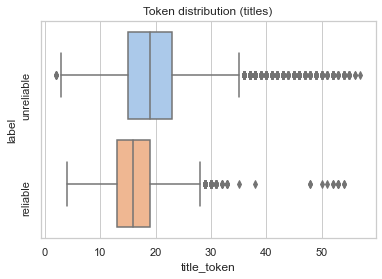

In [31]:
ax = sns.boxplot(data=train_df, y = 'label', x = 'title_token',  orient="h")
_ = plt.title('Token distribution (titles)')
_ = plt.yticks([0, 1], ['unreliable', 'reliable'], rotation='vertical')

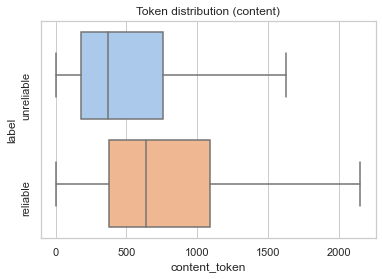

In [34]:
ax = sns.boxplot(data=train_df, y = 'label', x = 'content_token',  orient="h", showfliers = False)
_ = plt.title('Token distribution (content)')
_ = plt.yticks([0, 1], ['unreliable', 'reliable'], rotation='vertical')

# Truncate 

In [59]:
title = train_df.iloc[42].title
content = train_df.iloc[42].content
sep = '[SEP]'
t_e = tokenizer.encode_plus(
            title,
            add_special_tokens=True,
            # max_length = 512,
            return_token_type_ids = False,
            # padding = 'max_length',
            # truncation = True,
            return_attention_mask = True,
            return_tensors = 'pt'
        )
c_e = tokenizer.encode_plus(
            content,
            add_special_tokens=True,
            # max_length = 512,
            return_token_type_ids = False,
            # padding = 'max_length',
            # truncation = True,
            return_attention_mask = True,
            return_tensors = 'pt'
        )
total_length = t_e['input_ids'].shape[1] + c_e['input_ids'].shape[1]

if total_length > (512-

1197

# DataSet Class

In [48]:
'''
DataSet class
'''
class ReliableNewsDataset(Dataset):
    def __init__(self, data, tokenizer, max_token_len = 128, title_only=True):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
        self.title_only = title_only

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_row = self.data.iloc[index]
        
        text = data_row.title
        if not self.title_only:
            text = text + ' [SEP] ' + data_row.content
            
        labels = data_row.label

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length = self.max_token_len,
            return_token_type_ids = False,
            padding = 'max_length',
            truncation = True,
            return_attention_mask = True,
            return_tensors = 'pt'
        )

        return dict(
            title = title,
            input_ids = encoding['input_ids'].flatten(),
            attention_mask = encoding['attention_mask'].flatten(),
            labels = torch.tensor(labels, dtype=torch.float32)
        )

def create_reliable_news_dataloader(file_path, tokenizer, max_len=128, batch_size=8, shuffle=False, sample = None):
    df = jsonl_to_df(file_path)
    
    # Load only a partial dataset
    if sample:
        df = df.sample(sample)
    
    ds = ReliableNewsDataset(df, tokenizer, max_token_len = max_len)
    return DataLoader(ds, batch_size = batch_size, shuffle=shuffle)

tensor([102])